In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashion-images/data/fashion.csv
/kaggle/input/fashion-images/data/Apparel/Girls/Images/images_with_product_ids/41999.jpg
/kaggle/input/fashion-images/data/Apparel/Girls/Images/images_with_product_ids/40998.jpg
/kaggle/input/fashion-images/data/Apparel/Girls/Images/images_with_product_ids/30731.jpg
/kaggle/input/fashion-images/data/Apparel/Girls/Images/images_with_product_ids/38333.jpg
/kaggle/input/fashion-images/data/Apparel/Girls/Images/images_with_product_ids/37629.jpg
/kaggle/input/fashion-images/data/Apparel/Girls/Images/images_with_product_ids/36744.jpg
/kaggle/input/fashion-images/data/Apparel/Girls/Images/images_with_product_ids/3899.jpg
/kaggle/input/fashion-images/data/Apparel/Girls/Images/images_with_product_ids/5575.jpg
/kaggle/input/fashion-images/data/Apparel/Girls/Images/images_with_product_ids/30729.jpg
/kaggle/input/fashion-images/data/Apparel/Girls/Images/images_with_product_ids/8379.jpg
/kaggle/input/fashion-images/data/Apparel/Girls/Images/images_with_

To DO:
PCA
Check Pics are indexed correctly

In [2]:
# Approximate Nearest Neighbors
from annoy import AnnoyIndex
# Text Processing
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing import sequence
from sklearn.feature_extraction.text import TfidfVectorizer
# Other Processing
from sklearn.preprocessing import StandardScaler
#Display Results
import matplotlib.pyplot as plt
#Image Processing
import PIL
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50

In [3]:
df = pd.read_csv('../input/fashion-images/data/fashion.csv')
df.head()

,ProductId,Gender,Category,SubCategory,ProductType,Colour,Usage,ProductTitle,Image,ImageURL
0,42419,Girls,Apparel,Topwear,Tops,White,Casual,Gini and Jony Girls Knit White Top,42419.jpg,http://assets.myntassets.com/v1/images/style/p...
1,34009,Girls,Apparel,Topwear,Tops,Black,Casual,Gini and Jony Girls Black Top,34009.jpg,http://assets.myntassets.com/v1/images/style/p...
2,40143,Girls,Apparel,Topwear,Tops,Blue,Casual,Gini and Jony Girls Pretty Blossom Blue Top,40143.jpg,http://assets.myntassets.com/v1/images/style/p...
3,23623,Girls,Apparel,Topwear,Tops,Pink,Casual,Doodle Kids Girls Pink I love Shopping Top,23623.jpg,http://assets.myntassets.com/v1/images/style/p...
4,47154,Girls,Apparel,Bottomwear,Capris,Black,Casual,Gini and Jony Girls Black Capris,47154.jpg,http://assets.myntassets.com/v1/images/style/p...


In [4]:
df.loc[:, 'Gender':'Usage'].head(3)

,Gender,Category,SubCategory,ProductType,Colour,Usage
0,Girls,Apparel,Topwear,Tops,White,Casual
1,Girls,Apparel,Topwear,Tops,Black,Casual
2,Girls,Apparel,Topwear,Tops,Blue,Casual


In [5]:
df['metadata']=df.loc[:, 'Gender':'Usage'].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df.head(3)

,ProductId,Gender,Category,SubCategory,ProductType,Colour,Usage,ProductTitle,Image,ImageURL,metadata
0,42419,Girls,Apparel,Topwear,Tops,White,Casual,Gini and Jony Girls Knit White Top,42419.jpg,http://assets.myntassets.com/v1/images/style/p...,Girls Apparel Topwear Tops White Casual
1,34009,Girls,Apparel,Topwear,Tops,Black,Casual,Gini and Jony Girls Black Top,34009.jpg,http://assets.myntassets.com/v1/images/style/p...,Girls Apparel Topwear Tops Black Casual
2,40143,Girls,Apparel,Topwear,Tops,Blue,Casual,Gini and Jony Girls Pretty Blossom Blue Top,40143.jpg,http://assets.myntassets.com/v1/images/style/p...,Girls Apparel Topwear Tops Blue Casual


# Sort & Match Indices of Images

In [6]:
df = df.sort_values(by='ProductId', ascending=True)

# Define Function to Train Annoy Model

In [7]:
def train_annoy(data, trees=10):
    n_items = data.shape[0]
    n_feat = data.shape[1]

    print(f'Number of Items: {n_items}')
    print(f'Number of Features: {n_feat}')

    # Define Model
    ann_model = AnnoyIndex(n_feat, 'euclidean')
    # Add Items
    for i in range(n_items):
        v = list(data[i, :])
        ann_model.add_item(i, v)

    # Build Model
    ann_model.build(trees)
    
    return ann_model

# Metadata Model
- Vectorize
- Standard Scaling
- Model: KNN, ANNOY
- Recommender

In [8]:
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import StandardScaler


In [9]:
# Define Tokenizer
tokenizer = text.Tokenizer(num_words=None,
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                           lower = True,
                          char_level=False,
                          oov_token=None)

# Fit Tokenizer to Data
tokenizer.fit_on_texts(df['metadata'])

# Apply Tokenizer
text_sequences = tokenizer.texts_to_sequences(df['metadata'])

# Get padded, results - Matrix Form
metadata = sequence.pad_sequences(text_sequences)
metadata[0:5]

array([[ 0,  0,  6,  3,  2,  9,  2, 13,  9],
       [ 0,  0,  6,  3,  2,  9,  2, 13,  9],
       [ 0,  0,  6,  3,  2,  9,  2, 20,  9],
       [ 0,  0,  6,  3,  2,  9,  2, 13,  9],
       [ 0,  0,  0,  6,  3, 28, 29, 20,  1]], dtype=int32)

In [10]:
# Standard Scaling
scaler = StandardScaler()
scaler.fit(metadata)
metadata = scaler.transform(metadata)
metadata[0:5]

array([[-0.0414293 , -0.25999936,  1.15894415, -1.12819755, -0.46872952,
        -0.01667138, -1.02528982, -0.6315172 ,  1.04123327],
       [-0.0414293 , -0.25999936,  1.15894415, -1.12819755, -0.46872952,
        -0.01667138, -1.02528982, -0.6315172 ,  1.04123327],
       [-0.0414293 , -0.25999936,  1.15894415, -1.12819755, -0.46872952,
        -0.01667138, -1.02528982, -0.00404087,  1.04123327],
       [-0.0414293 , -0.25999936,  1.15894415, -1.12819755, -0.46872952,
        -0.01667138, -1.02528982, -0.6315172 ,  1.04123327],
       [-0.0414293 , -0.25999936, -0.72941677, -0.34554248, -0.28375831,
         1.85806148,  0.9120546 , -0.00404087, -0.32923557]])

In [11]:
n_feat = metadata.shape[1]
n_feat

9

In [12]:
n_items = metadata.shape[0]
n_items

2906

In [13]:
# Define Model
ann_meta = train_annoy(metadata)

Number of Items: 2906
Number of Features: 9


In [14]:
# Verify Number Items
ann_meta.get_n_items()

2906

In [15]:
# Get Nearest Neighbor Results (item, # neighbors)
ann_meta.get_nns_by_item(3, 10)

[0, 1, 77, 83, 85, 87, 94, 95, 113, 170]

In [16]:
# Get Vector
ann_meta.get_item_vector(0)

[-0.041429303586483,
 -0.2599993646144867,
 1.1589441299438477,
 -1.1281975507736206,
 -0.46872952580451965,
 -0.01667138561606407,
 -1.02528977394104,
 -0.631517231464386,
 1.0412333011627197]

# Description-Based Model

In [17]:
df['ProductTitle'].head(3)

1503      Nike Men Air Zoom Century Shoes
1743         Nike Men White Cricket Shoes
1635    Reebok Men's Ventilator Ubiq Shoe
Name: ProductTitle, dtype: object

In [18]:
# Define Tokenizer
tokenizer = text.Tokenizer(num_words=None,
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                          lower = True,
                          char_level=False,
                          oov_token=None)

# Fit Tokenizer to Data
tokenizer.fit_on_texts(df['ProductTitle'])

# Apply Tokenizer
text_sequences = tokenizer.texts_to_sequences(df['ProductTitle'])

# Get padded, results - Matrix Form
titledata = sequence.pad_sequences(text_sequences)
titledata[0:5]

array([[  0,   0,   0,   0,   0,   0,  27,   2,  72, 217, 682,   4],
       [  0,   0,   0,   0,   0,   0,   0,  27,   2,   9, 683,   4],
       [  0,   0,   0,   0,   0,   0,   0,  73,  38, 684, 685,  22],
       [  0,   0,   0,   0,   0,   0,   0,  73,  38, 686, 687,  22],
       [  0,   0,   0,   0,   0,   0,   0, 237,   2, 362,  19,  65]],
      dtype=int32)

In [19]:
titledata.shape

(2906, 12)

In [20]:
vectorizer = TfidfVectorizer(max_features = 300) # Note: max_features only considers features ordered by term frequency
titledata = vectorizer.fit_transform(df['ProductTitle'])

In [21]:
vectorizer.get_feature_names()[40:50]

['brown',
 'buckaroo',
 'cabana',
 'canvas',
 'capri',
 'capris',
 'carlton',
 'casual',
 'cat',
 'catwalk']

In [22]:
titledata.shape

(2906, 300)

In [23]:
# Change from sparse to dense matrix
titledata = titledata.todense()

# Standard Scaling
scaler = StandardScaler()
scaler.fit(titledata)
titledata = scaler.transform(titledata)
titledata[0:5]

array([[-0.07655825, -0.05564159, -0.0371262 , ..., -0.09644419,
        -0.21153994, 19.66149742],
       [-0.07655825, -0.05564159, -0.0371262 , ..., -0.09644419,
        -0.21153994, -0.04911962],
       [-0.07655825, -0.05564159, -0.0371262 , ..., -0.09644419,
        -0.21153994, -0.04911962],
       [-0.07655825, -0.05564159, -0.0371262 , ..., -0.09644419,
        -0.21153994, -0.04911962],
       [-0.07655825, -0.05564159, -0.0371262 , ..., -0.09644419,
        -0.21153994, -0.04911962]])

## Train Model

In [24]:
ann_text = train_annoy(titledata)

Number of Items: 2906
Number of Features: 300


In [25]:
# Verify correct number items
ann_text.get_n_items()

2906

In [26]:
# Get Nearest Neighbor Results (item, # neighbors)
ann_text.get_nns_by_item(3, 10)

[2, 3, 170, 255, 312, 305, 2409, 2411, 532, 1024]

In [27]:
# Get Vector
ann_text.get_item_vector(0)[0:10]

[-0.07655824720859528,
 -0.05564158782362938,
 -0.03712620213627815,
 -0.03709443658590317,
 -0.04874968156218529,
 -0.06687930226325989,
 -0.2353411167860031,
 9.110747337341309,
 -0.06686814874410629,
 -0.05870953947305679]

# Image Similarity
- Use ResNet50 to vectorize images

https://www.tensorflow.org/tutorials/images/transfer_learning
https://pyimagesearch.com/2019/05/27/keras-feature-extraction-on-large-datasets-with-deep-learning/
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

https://keras.io/api/preprocessing/image/


In [28]:
#path = '../input/fashion-images/data/Apparel/Boys/Images/images_with_product_ids'
path = '../input/fashion-images/data/'
pic1 = '../input/fashion-images/data/Apparel/Boys/Images/images_with_product_ids/10649.jpg'

In [29]:
# Rescale RBG
datagen = ImageDataGenerator(rescale=1/255)
# Data
generator = datagen.flow_from_directory(
    directory=path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 2906 images belonging to 2 classes.


In [30]:
generator.filenames[0:5]

['Apparel/Boys/Images/images_with_product_ids/10054.jpg',
 'Apparel/Boys/Images/images_with_product_ids/10649.jpg',
 'Apparel/Boys/Images/images_with_product_ids/10671.jpg',
 'Apparel/Boys/Images/images_with_product_ids/12840.jpg',
 'Apparel/Boys/Images/images_with_product_ids/12844.jpg']

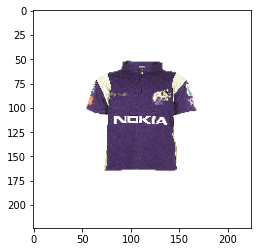

In [31]:
img = generator.next()
plt.imshow(img[0])
plt.show()

In [32]:
# Create Image Map
image_map =[]
filenames = generator.filenames
for f in range(len(filenames)):
    file = filenames[f]
    image_map.append(file[file.rfind("/")+1:file.find(".")])


In [33]:
image_map[0:5]

['10054', '10649', '10671', '12840', '12844']

In [34]:
# ResNet 50 Model
## Perform Average Pooling on last layer to get 2D tensor
model = ResNet50(weights="imagenet", 
                 include_top=False,
                 input_shape = (224, 224, 3),
                 pooling='avg',
                 classes=None)

2022-03-30 14:08:19.059755: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


94781440/94765736 [==============================] - 3s 0us/step


In [35]:
imagedata = model.predict(generator)

2022-03-30 14:08:25.144488: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [36]:
imagedata.shape

(2906, 2048)

In [37]:
# Standard Scaling
scaler = StandardScaler()
scaler.fit(imagedata)
imagedata = scaler.transform(imagedata)
imagedata[0]

array([ 0.        , -0.03774784, -0.14486618, ...,  0.2939023 ,
       -0.04207953,  0.        ], dtype=float32)

## Train Image Model

In [38]:
ann_image = train_annoy(imagedata)

Number of Items: 2906
Number of Features: 2048


In [39]:
# Verify correct number items
ann_image.get_n_items()

2906

In [40]:
item=100
ann_image.get_nns_by_item(item, 10)

[100, 192, 193, 101, 194, 195, 188, 189, 99, 572]

Item Index: 100


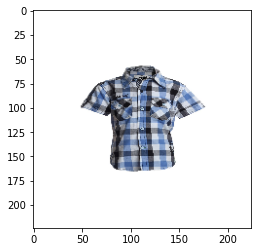

In [41]:
# Display Image and Results
print("Item Index: {}".format(item))
img = generator[item]
plt.imshow(img[0])
plt.show()

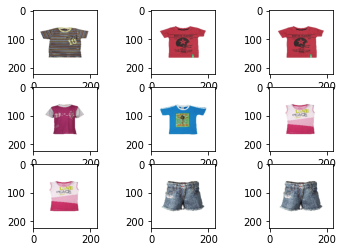

In [42]:
# Display Image and Results

item=3
results = ann_image.get_nns_by_item(item, 9)

for i in range(len(results)):
    plt.subplot(330+1+i)
    plt.imshow(generator[results[i]][0])
plt.show()

In [43]:
ann_image.get_item_vector(0)[0:5]

[0.0, -0.03774784132838249, -0.1448661834001541, 0.0, 0.5530811548233032]

# Comparing Models

Our goal is to develop the "best" recommendation model possible from our image, text, and metadata models. By definition this is an unsupervised problem without user data.  In practice, we would experiment by A/B testing different models in order to observe which model drives the most clicks, likes, revenue, etc. However, rather than simply employing a grid search approach, we can make some inferences about which models may be the best canidates for testing.

In [44]:
n_items = ann_image.get_n_items()
n_features_image = imagedata.shape[1]
n_features_metadata= metadata.shape[1]
n_features_text = titledata.shape[1]

Calculate Pairwise Distances

In [45]:
# Calculate Pairwise Distances
def calc_pairwise(model):

    # Get Triangle Indices
    t_ind = np.triu_indices(n=n_items, k = 0, m=n_items)
    
    # Create empty list for results
    l = []
    
    # Get Pairwise distances
    for t in range(len(t_ind[0])):
        d = model.get_distance(t_ind[0][t], t_ind[1][t])
        l.append(d)
    
    # Convert to numpy array
    data = np.array(l)
    
    return data

def plot_distance_results(data, model_name):
    fig = plt.figure(figsize=(5,5))
    ax = plt.hist(x = data, bins=100)
    plt.xlabel('Euclidean Distance')
    plt.xlim([0,500])
    plt.ylabel('Frequency')
    plt.title('Model Distances - '+ model_name)
    plt.show()

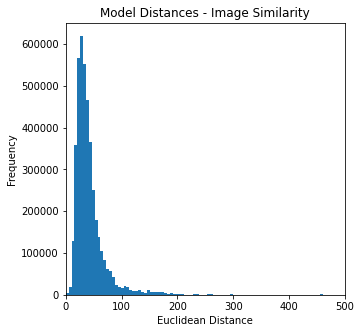

In [46]:
dist_image = calc_pairwise(ann_image)
plot_distance_results(data = dist_image, model_name="Image Similarity")

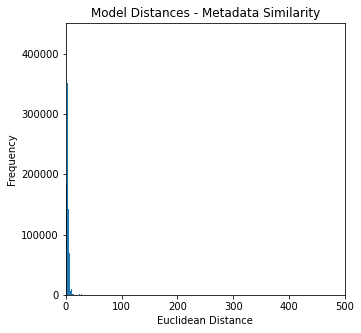

In [47]:
dist_metadata = calc_pairwise(ann_meta)
plot_distance_results(data = dist_metadata, model_name="Metadata Similarity")

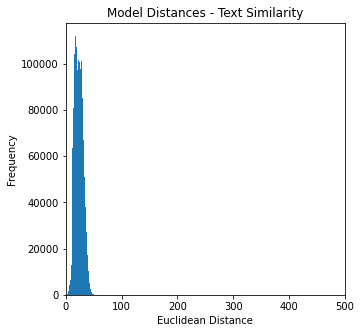

In [48]:
dist_text = calc_pairwise(ann_text)
plot_distance_results(data = dist_text, model_name="Text Similarity")

In [49]:
dist_text

array([ 0.        , 22.33717918, 25.49503326, ...,  0.        ,
       17.6282444 ,  0.        ])

In [50]:
dist_image

array([ 0.        , 32.70769119, 29.47712898, ...,  0.        ,
       29.24152946,  0.        ])

In [51]:
#df = pd.DataFrame([dist_image, dist_text, dist_metadata], columns=['image', 'text', 'metadata'])

data = {
    'image': dist_image,
    'text': dist_text,
    'metadata': dist_metadata
}
df = pd.DataFrame(data)
df.corr('spearman')

,image,text,metadata
image,1.000000,-0.007957,0.002575
text,-0.007957,1.000000,0.171990
metadata,0.002575,0.171990,1.000000


In [52]:
from sklearn.decomposition import PCA

In [53]:
# Empty Data Matrix
data_matrix_image = np.zeros((n_items,n_features_image))
# Add Data from model
for i in range(n_items):
  data_matrix_image[i, :]=ann_image.get_item_vector(i)

In [54]:
n_pc = 15
# PCA Analysis
pca = PCA(n_components = n_pc)
pca.fit(data_matrix_image)
pca_image = pca.explained_variance_ratio_
pca_image

array([0.15565028, 0.08629066, 0.06221551, 0.04255706, 0.03219873,
       0.0270339 , 0.02114279, 0.02007976, 0.01780827, 0.01615237,
       0.01499052, 0.01385531, 0.01273113, 0.01102191, 0.01065164])

In [55]:
N_PC = 9 #Number of Principal Components

def get_pca_varexplained(model, n_features):
    
    # Empty Data Matrix
    data_matrix = np.zeros((n_items,n_features))
    # Add Data from model
    for i in range(n_items):
      data_matrix[i, :]=model.get_item_vector(i)
    
    # PCA Analysis
    pca = PCA(n_components = N_PC)
    pca.fit(data_matrix)
    pca_explvar = pca.explained_variance_ratio_
    return pca_explvar

In [56]:
pca_image = get_pca_varexplained(ann_image, n_features_image)
pca_text = get_pca_varexplained(ann_text, n_features_text)
pca_metadata = get_pca_varexplained(ann_meta, n_features_metadata)

In [57]:
data = {
    'image': pca_image,
    'text': pca_text,
    'metadata': pca_metadata
}
df_pca = pd.DataFrame(data)
df_pca

,image,text,metadata
0,0.155650,0.018700,0.280099
1,0.086291,0.014563,0.204225
2,0.062216,0.012416,0.130031
3,0.042557,0.011072,0.109957
4,0.032199,0.010040,0.105628
5,0.027034,0.009879,0.079791
6,0.021143,0.009016,0.038097
7,0.020080,0.008658,0.031530
8,0.017808,0.008514,0.020642


From this analysis of the image, text (description), and metadata similarity models some important observations emerge:
* The variance explained ratio for the first several principal components is highest for metadata and image. This suggests that these may be more important models to weight.
* The Spearman Correlation Coefficient (rank based, non-parametric) shows little correlation between metadata and image
* The tex model seems to provide limited predictive value, and can likely be improved upon by implementing word embeddings